# IndicBART and IndicNLG notebook

By Raj Dabre (NICT, Japan)

## 安装和导入包

In [1]:
!pip install transformers
!pip install sentencepiece==0.1.95
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 31.1 MB/s 
     |████████████████████████████████| 163 kB 67.2 MB/s 
     |████████████████████████████████| 7.6 MB 55.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 32.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 安装IndicNLP 

数据转换脚本

In [2]:
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git
!pip install indic-nlp-library

from indicnlp import common
common.set_resources_path("/content/indic_nlp_resources")

from indicnlp import loader
loader.load()
from indicnlp.transliterate.unicode_transliterate import UnicodeIndicTransliterator

Cloning into 'indic_nlp_resources'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 139 (delta 2), reused 2 (delta 0), pack-reused 126
Receiving objects: 100% (139/139), 149.77 MiB | 15.56 MiB/s, done.
Resolving deltas: 100% (53/53), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40 kB 6.3 MB/s 
     |████████████████████████████████| 2.8 MB 47.2 MB/s 


## 加载tokenizer和model

---



In [3]:
# Import all the necessary classes and initialize the tokenizer and model.
from transformers import AlbertTokenizer, MBartForConditionalGeneration

tokenizer = AlbertTokenizer.from_pretrained("ai4bharat/IndicBART", do_lower_case=False, use_fast=False, keep_accents=True)

model = MBartForConditionalGeneration.from_pretrained("ai4bharat/IndicBART")

Downloading:   0%|          | 0.00/1.90M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/221 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/398 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/498 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/832 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/976M [00:00<?, ?B/s]

## tokenizer初始化

In [4]:
tokenizer

PreTrainedTokenizer(name_or_path='ai4bharat/IndicBART', vocab_size=64000, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '<unk>', 'sep_token': '[SEP]', 'pad_token': '<pad>', 'cls_token': '[CLS]', 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=True), 'additional_special_tokens': ['<s>', '</s>', '<2as>', '<2bn>', '<2en>', '<2gu>', '<2hi>', '<2kn>', '<2ml>', '<2mr>', '<2or>', '<2pa>', '<2ta>', '<2te>']})

In [5]:
bos_id = tokenizer._convert_token_to_id_with_added_voc("<s>")
eos_id = tokenizer._convert_token_to_id_with_added_voc("</s>")
pad_id = tokenizer._convert_token_to_id_with_added_voc("<pad>")
# To get lang_id use any of ['<2as>', '<2bn>', '<2en>', '<2gu>', '<2hi>', '<2kn>', '<2ml>', '<2mr>', '<2or>', '<2pa>', '<2ta>', '<2te>']

## tokenizer 如何工作？
tokenizer负责将单词分割成更小的单元。
这是必需的，因此我们不需要大量的词汇表。
大词汇意味着大模型。
大模型意味着它很难使用。
tokenizer也称为子词分割。

In [6]:
# First tokenize the input and outputs. 
# The format below is how IndicBART was trained so the input should be "Sentence </s> <2xx>" where xx is the language code. 
# Similarly, the output should be "<2yy> Sentence </s>". 

input_sentence = "I am a boy"
output_sentence = "मैं एक लड़का हूँ"

# The input and output sentence is what the model needs for learning.
# Current example is translation but consider the following examples:
# Summarization: 
# Input is "There was a child. She liked food. She decided to learn to make food. She became a world class chef. She won an award." 
# Output is "A child learned cooking and won an award."
# Paraphrasing: 
# Input is "I love to eat food."
# Output is "I am a foodie"

inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids

out = tokenizer(output_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids

print("Original input sentence:", input_sentence)
print("Segmented input sentence:", tokenizer.convert_ids_to_tokens(inp[0]))
print("Input sentence as tensor: ", inp)
print("Original output sentence:", output_sentence)
print("Segmented output sentence:", tokenizer.convert_ids_to_tokens(out[0]))
print("Output sentence as tensor:", out)

Original input sentence: I am a boy
Segmented input sentence: ['▁I', '▁am', '▁a', '▁boy']
Input sentence as tensor:  tensor([[  466,  1981,    80, 25573]])
Original output sentence: मैं एक लड़का हूँ
Segmented output sentence: ['▁मैं', '▁एक', '▁लड़का', '▁हूँ']
Output sentence as tensor: tensor([[  942,    43, 32720,  8384]])


## 它如何处理非梵文和非罗马语言？

In [7]:
input_sentence = "நான் ஒரு பையன்"
inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
print("Original input sentence:", input_sentence)
print("Segmented input sentence:", tokenizer.convert_ids_to_tokens(inp[0]))
print("Input sentence as tensor: ", inp)


Original input sentence: நான் ஒரு பையன்
Segmented input sentence: ['▁', 'ந', 'ா', 'ன', '்', '▁', 'ஒ', 'ர', 'ு', '▁', 'ப', 'ை', 'ய', 'ன', '்']
Input sentence as tensor:  tensor([[   41, 60827, 59856, 60093, 59479,    41, 62010, 59792, 59655,    41,
         59785, 60095, 59980, 60093, 59479]])


## 那看起来不对。 为什么？

IndicBART 是单脚本模型。 因此，让我们使用 IndicNLP 库转换为梵文。

In [8]:
input_sentence = UnicodeIndicTransliterator.transliterate("நான் ஒரு பையன்","ta","hi")
inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
print("Original input sentence:", input_sentence)
print("Segmented input sentence:", tokenizer.convert_ids_to_tokens(inp[0]))
print("Input sentence as tensor: ", inp)

Original input sentence: नाऩ् ऒरु पैयऩ्
Segmented input sentence: ['▁नाऩ्', '▁ऒरु', '▁प', 'ैयऩ्']
Input sentence as tensor:  tensor([[ 1170,   140,    26, 39188]])


## 好多了！ 现在我们将使用印地语示例！
但是，如果您打算使用非梵文和非罗马文字语言，那么不要忘记音译。 另外，完成后，不要忘记重新音译为原始语言。

## 让我们看看 IndicBART 模型能做什么。

In [9]:
input_sentence = "I am a boy </s> <2en>" ## The last 2 tokens are needed by IndicBART to explicitly mark the end of the sentence and indicate the language.
inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids

# If you have a gpu then move the model to a gpu. For now we do!

model.to(0)

# Move the tensors to gpu too else you get a boo boo

inp=inp.to(0)
out=out.to(0)

# For generation we should set the model in evaluation mode. No dropouts.

model.eval() # Set dropouts to zero

# Pass the input and get the output

model_output=model.generate(inp, 
                            use_cache=True, 
                            num_beams=4, 
                            max_length=20, 
                            min_length=1, 
                            early_stopping=True, 
                            pad_token_id=pad_id, 
                            bos_token_id=bos_id, 
                            eos_token_id=eos_id, 
                            decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2hi>"))

# Play with num_beams, max_length, min_length. 
# num_beams increases the search complexity and generates multiple alternatives during generation.
# Note decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2en>")
# Change <2hi> to <2xx> where xx is the desired target language.

# Output is a tensor and we need to convert it back into a sentence.

print("Model output as tensor:", model_output)

# What is this in tokens?

print("Model output as segmented sentence:", tokenizer.convert_ids_to_tokens(model_output[0]))

# Decode using the tokenizer to get output strings.

decoded_output=tokenizer.decode(model_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)

print("Models actual output:", decoded_output) 


Model output as tensor: tensor([[64006,   466,  1981,    80, 25573, 64001]], device='cuda:0')
Model output as segmented sentence: ['<2hi>', '▁I', '▁am', '▁a', '▁boy', '</s>']
Models actual output: I am a boy


## 那很尴尬。 让我们尝试使用印地语作为输入。

In [ ]:
# Tokenize 
hin_inp = tokenizer("मैं एक लड़का हूँ </s> <2hi>", add_special_tokens=False, return_tensors="pt", padding=True).input_ids.to(0)

# Generate

model_output=model.generate(hin_inp, 
                            use_cache=True, 
                            num_beams=4, 
                            max_length=20, 
                            min_length=1, 
                            early_stopping=True, 
                            pad_token_id=pad_id, 
                            bos_token_id=bos_id, 
                            eos_token_id=eos_id, 
                            decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2hi>"))
# Output is a tensor and we need to convert it back into a sentence.

print("Model output as tensor:", model_output)

# What is this in tokens?

print("Model output as segmented sentence:", tokenizer.convert_ids_to_tokens(model_output[0]))

# Decode using the tokenizer to get output strings.

decoded_output=tokenizer.decode(model_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)

print("Models actual output:", decoded_output) 


Model output as tensor: tensor([[64006,   942,    43, 32720,  8384, 64001]], device='cuda:0')
Model output as segmented sentence: ['<2hi>', '▁मैं', '▁एक', '▁लड़का', '▁हूँ', '</s>']
Models actual output: मैं एक लड़का हूँ


## 等一下！
IndicBART 没有对任何任务进行微调。 它现在不能翻译或总结或任何东西。

但它可以做一些简单的事情。 让我们看看它是什么。

In [10]:
# Tokenize 
hindi_input_sentence = "मैं एक [MASK] हूँ </s> <2hi>"
hin_inp = tokenizer(hindi_input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids.to(0)

# What does this look like?

print("Original input sentence:", hindi_input_sentence)
print("Segmented input sentence:", tokenizer.convert_ids_to_tokens(hin_inp[0]))
print("Input sentence as tensor: ", hin_inp)

# Generate

model_output=model.generate(hin_inp, use_cache=True, num_beams=4, max_length=20, min_length=1, early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2hi>"))
# Output is a tensor and we need to convert it back into a sentence.

print("Model output as tensor:", model_output)

# What is this in tokens?

print("Model output as segmented sentence:", tokenizer.convert_ids_to_tokens(model_output[0]))

# Decode using the tokenizer to get output strings.

decoded_output=tokenizer.decode(model_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)

print("Models actual output:", decoded_output) 


Original input sentence: मैं एक [MASK] हूँ </s> <2hi>
Segmented input sentence: ['▁मैं', '▁एक', '[MASK]', '▁हूँ', '</s>', '<2hi>']
Input sentence as tensor:  tensor([[  942,    43,     4,  8384, 64001, 64006]], device='cuda:0')
Model output as tensor: tensor([[64006,   942,    43,  6540,  8384, 64001]], device='cuda:0')
Model output as segmented sentence: ['<2hi>', '▁मैं', '▁एक', '▁कलाकार', '▁हूँ', '</s>']
Models actual output: मैं एक कलाकार हूँ


## 它可以预测丢失的（MASKED）单词！
它还能做什么？ 它可以为 MASK 提供多个替代品吗？


In [11]:
# Lets use num_return_sequences=4 to get all 4 options that the model generated.

model_output=model.generate(hin_inp, use_cache=True, num_beams=4, max_length=20, min_length=1, num_return_sequences=4, early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2hi>"))

for i, mod_out in enumerate(model_output):
  print("Output ", i)
  print("Model output as tensor:", mod_out)

  print("Model output as segmented sentence:", tokenizer.convert_ids_to_tokens(mod_out))

  decoded_output=tokenizer.decode(mod_out, skip_special_tokens=True, clean_up_tokenization_spaces=False)

  print("Models actual output:", decoded_output) 


Output  0
Model output as tensor: tensor([64006,   942,    43,  6540,  8384, 64001], device='cuda:0')
Model output as segmented sentence: ['<2hi>', '▁मैं', '▁एक', '▁कलाकार', '▁हूँ', '</s>']
Models actual output: मैं एक कलाकार हूँ
Output  1
Model output as tensor: tensor([64006,   942,    43,  4316,  8384, 64001], device='cuda:0')
Model output as segmented sentence: ['<2hi>', '▁मैं', '▁एक', '▁पत्रकार', '▁हूँ', '</s>']
Models actual output: मैं एक पत्रकार हूँ
Output  2
Model output as tensor: tensor([64006,   942,    43,   530,  8384, 64001], device='cuda:0')
Model output as segmented sentence: ['<2hi>', '▁मैं', '▁एक', '▁महिला', '▁हूँ', '</s>']
Models actual output: मैं एक महिला हूँ
Output  3
Model output as tensor: tensor([64006,   942,    43, 18460,  8384, 64001], device='cuda:0')
Model output as segmented sentence: ['<2hi>', '▁मैं', '▁एक', '▁इंसान', '▁हूँ', '</s>']
Models actual output: मैं एक इंसान हूँ


## Yes it can!

What about for English?

In [ ]:
input_sentence = "I am a [MASK] </s> <2en>"
inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids.to(0)

model_output=model.generate(inp, use_cache=True, num_beams=4, max_length=20, min_length=1, num_return_sequences=4, 
                            early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, 
                            decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2en>"))

for i, mod_out in enumerate(model_output):
  print("Output ", i)
  print("Model output as tensor:", mod_out)

  print("Model output as segmented sentence:", tokenizer.convert_ids_to_tokens(mod_out))

  decoded_output=tokenizer.decode(mod_out, skip_special_tokens=True, clean_up_tokenization_spaces=False)

  print("Models actual output:", decoded_output) 


Output  0
Model output as tensor: tensor([64004,   466,  1981,    80,  9684,     6, 64001,     0,     0],
       device='cuda:0')
Model output as segmented sentence: ['<2en>', '▁I', '▁am', '▁a', '▁woman', '.', '</s>', '<pad>', '<pad>']
Models actual output: I am a woman.
Output  1
Model output as tensor: tensor([64004,   466,  1981,    80, 17225,     6, 64001,     0,     0],
       device='cuda:0')
Model output as segmented sentence: ['<2en>', '▁I', '▁am', '▁a', '▁student', '.', '</s>', '<pad>', '<pad>']
Models actual output: I am a student.
Output  2
Model output as tensor: tensor([64004,   466,  1981,    80, 36817,     6, 64001,     0,     0],
       device='cuda:0')
Model output as segmented sentence: ['<2en>', '▁I', '▁am', '▁a', '▁doctor', '.', '</s>', '<pad>', '<pad>']
Models actual output: I am a doctor.
Output  3
Model output as tensor: tensor([64004,   466,  1981,    80,    41, 26150, 12172,  6584, 64001],
       device='cuda:0')
Model output as segmented sentence: ['<2en>', '▁

## So what is IndicBART?

It is a pre-trained model.
It was trained with "corrupted" sentences as input and actual sentences as output.
Corruption --> Replace tokens or phrases with [MASK]

## How do I make IndicBART do translation?

You fine-tune it on parallel data.
Parallel data looks like:

I am a boy ||| मैं एक लड़का हूँ

I love food ||| मुझे खाना पसंद हैं 

If you want summarization then your data has to look like:

There was a child. She liked food. She decided to learn to make food. She became a world class chef. She won an award. |||  A child learned cooking and won an award.



## Lets train a model to do translation.

First lets get some parallel corpora and print the top 10 lines.

In [ ]:
!rm -rf en-hi.txt.zip TED* README LICENSE
!wget https://object.pouta.csc.fi/OPUS-TED2020/v1/moses/en-hi.txt.zip
!unzip en-hi.txt.zip
!ls
!head TED2020.en-hi.en
!head TED2020.en-hi.hi
!echo Number of lines in the corpus:
!wc -l TED2020.en-hi.??

--2022-07-28 09:45:02--  https://object.pouta.csc.fi/OPUS-TED2020/v1/moses/en-hi.txt.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3784055 (3.6M) [application/zip]
Saving to: ‘en-hi.txt.zip’

en-hi.txt.zip       100%[===================>]   3.61M  3.39MB/s    in 1.1s    

2022-07-28 09:45:04 (3.39 MB/s) - ‘en-hi.txt.zip’ saved [3784055/3784055]

Archive:  en-hi.txt.zip
  inflating: README                  
  inflating: LICENSE                 
  inflating: TED2020.en-hi.en        
  inflating: TED2020.en-hi.hi        
  inflating: TED2020.en-hi.xml       
en-hi.txt.zip	     LICENSE  sample_data	TED2020.en-hi.hi
indic_nlp_resources  README   TED2020.en-hi.en	TED2020.en-hi.xml
Thank you so much, Chris. 
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful. 

## Now we have a nice sized parallel corpus to train our translation model.

Lets create a few important functions and then go for it.

In [ ]:
## Batching
import sys
import random
import numpy as np
import torch

def yield_corpus_indefinitely_bi(corpus, language):
    """This shuffles the corpus at the beginning of each epoch and returns sentences indefinitely."""
    epoch_counter = 0
    num_lines = len(corpus)
    num_sentences_before_sort = 20000
    num_sorted_segments = (num_lines // num_sentences_before_sort) + 1
    while True:
        print("Shuffling corpus:", language)
        random.shuffle(corpus)
        for src_line, tgt_line in corpus:
            yield src_line, tgt_line
        epoch_counter += 1
        print("Finished epoch", epoch_counter, "for language:", language)
    return None, None ## We should never reach this point.


def generate_batches_bilingual(tok, num_batches, is_summarization=False, batch_size=16, src_lang="en", tgt_lang="hi", src_file_prefix="TED2020.en-hi", tgt_file_prefix="TED2020.en-hi"):
    """Generates the source, target and source attention masks for the training set. 
    The source and target sentences are ignored if empty and are truncated if longer than a 
    threshold. The batch size in this context is the maximum number of tokens in the batch post padding."""
    batch_count = 0
    mask_tok = "[MASK]"

    language_list = [src_lang+"-"+tgt_lang]
    print("Training for:", language_list)
    src_file_content = open(src_file_prefix+"."+src_lang).readlines()
    tgt_file_content = open(tgt_file_prefix+"."+tgt_lang).readlines()
    file_content = list(zip(src_file_content, tgt_file_content))
    file_iterator = yield_corpus_indefinitely_bi(file_content, src_lang+"-"+tgt_lang)
    slang = "<2"+src_lang+">"
    tlang = "<2"+tgt_lang+">"
            
    while batch_count != num_batches:
        curr_batch_count = 0
        encoder_input_batch = []
        decoder_input_batch = []
        decoder_label_batch = []
        batch_count += 1
        max_src_sent_len = 0
        max_tgt_sent_len = 0
        sents_in_batch = 0
        while True:
            src_sent, tgt_sent = next(file_iterator)
            src_sent = src_sent.strip()
            tgt_sent = tgt_sent.strip()
            ## Uncomment the following block for non-Devanagari non-Romanic languages.
            # if slang != "<2en>" and slang != "<2hi>": # Transliterate to Devanagari
            #     src_sent = UnicodeIndicTransliterator.transliterate(src_sent, slang[2:4], "hi")
            # if tlang != "<2en>" and tlang != "<2hi>": # Transliterate to Devanagari
            #     tgt_sent = UnicodeIndicTransliterator.transliterate(tgt_sent, tlang[2:4], "hi")
            src_sent_split = src_sent.split(" ")
            tgt_sent_split = tgt_sent.split(" ")
            tgt_sent_len = len(tgt_sent_split)
            src_sent_len = len(src_sent_split)
            
            if src_sent_len < 1 or tgt_sent_len < 1:
                continue
            else:   # Initial truncation
                if src_sent_len >= 100:
                    src_sent_split = src_sent_split[:100]
                    src_sent = " ".join(src_sent_split)
                    src_sent_len = 100
                if tgt_sent_len >= 100:
                    tgt_sent_split = tgt_sent_split[:100]
                    tgt_sent = " ".join(tgt_sent_split)
                    tgt_sent_len = 100
            
            if (slang == tlang and not is_summarization): ## Copying task should DEFINITELY use source masking unless we are doing summarization. We wont bother using this condition for cross distillation. In fact a single condition based on a flag should be sufficient but I am too lazy to make a change. Come fight me if you disagree.
                mask_percent = random.uniform(0.3, 0.4)
                mask_count = 0
                max_mask_count = int(mask_percent*src_sent_len)
                spans_to_mask = list(np.random.poisson(3.5, 1000))
                curr_sent_len = src_sent_len
                while mask_count < max_mask_count:
                    try:
                        span_to_mask = spans_to_mask[0]
                        del spans_to_mask[0]
                        if span_to_mask > (max_mask_count-mask_count): ## Cant mask more than the allowable number of tokens.
                            continue
                        idx_to_mask = random.randint(0, (curr_sent_len-1)-(span_to_mask-1))
                        if mask_tok not in src_sent_split[idx_to_mask:idx_to_mask+span_to_mask]:
                            actually_masked_length = len(src_sent_split[idx_to_mask:idx_to_mask+span_to_mask]) ## If at the end of the sentence then we have likely masked fewer tokens.
                            src_sent_split[idx_to_mask:idx_to_mask+span_to_mask] = [mask_tok]
                            mask_count += actually_masked_length # We assume that with a low probability there are mask insertions when span lengths are 0 which may cause more mask tokens than planned. I have decided not to count these insersions towards the maximum maskable limit. This means that the total number of mask tokens will be a bit higher than what it should be. 
                            curr_sent_len -= (actually_masked_length-1)
                    except:
                        break ## If we cannot get a properly masked sentence despite all our efforts then we just give up and continue with what we have so far.
                src_sent = " ".join(src_sent_split)

            
            iids = tok(src_sent + " </s> " + slang, add_special_tokens=False, return_tensors="pt").input_ids
            curr_src_sent_len = len(iids[0])
            if curr_src_sent_len > 256:
                src_sent = tok.decode(iids[0][0:256-2], skip_special_tokens=True, clean_up_tokenization_spaces=False)
                curr_src_sent_len = 256
            
            iids = tok(tlang + " " + tgt_sent, add_special_tokens=False, return_tensors="pt").input_ids
            curr_tgt_sent_len = len(iids[0])
            if curr_tgt_sent_len > 256:
                tgt_sent = tok.decode(iids[0][1:256], skip_special_tokens=True, clean_up_tokenization_spaces=False)
                curr_tgt_sent_len = 256
            
            
            encoder_input_batch.append(src_sent + " </s> " + slang)
            decoder_input_batch.append(tlang + " " + tgt_sent)
            decoder_label_batch.append(tgt_sent + " </s>")
            sents_in_batch += 1
            if sents_in_batch == batch_size:
                    break
                
        input_ids = tok(encoder_input_batch, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
        input_masks = (input_ids != tok.pad_token_id).int()
        decoder_input_ids = tok(decoder_input_batch, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
        labels = tok(decoder_label_batch, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
        yield input_ids, input_masks, decoder_input_ids, labels

## Loss

def label_smoothed_nll_loss(lprobs, target, epsilon, ignore_index=None):
    """From fairseq. This returns the label smoothed cross entropy loss."""
    if target.dim() == lprobs.dim() - 1:
        target = target.unsqueeze(-1)
    nll_loss = -lprobs.gather(dim=-1, index=target)
    smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
    if ignore_index is not None:
        pad_mask = target.eq(ignore_index)
        nll_loss.masked_fill_(pad_mask, 0.0)
        smooth_loss.masked_fill_(pad_mask, 0.0)
        denominator = (1.0 - 1.0*pad_mask)
        denominator = denominator.sum()
    else:
        nll_loss = nll_loss.squeeze(-1)
        smooth_loss = smooth_loss.squeeze(-1)
        denominator = 1.0
    
    if ignore_index is not None:
        nll_loss = nll_loss.sum()
        smooth_loss = smooth_loss.sum()
    else:
        nll_loss = nll_loss.mean()
        smooth_loss = smooth_loss.mean()
        
    eps_i = epsilon / lprobs.size(-1)
    loss = (1.0 - epsilon) * nll_loss + eps_i * smooth_loss
    loss = loss/denominator
    return loss

## Lets set the optimizers and learning rate schedulers

In [ ]:
from transformers import get_linear_schedule_with_warmup
from transformers import AdamW

no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay) and p.requires_grad],
            "weight_decay": 0.00001,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay) and p.requires_grad],
            "weight_decay": 0.0,
        },
    ] ## We suppose that weight decay will be used except for biases and layer norm weights.

print("Optimizing", [n for n, p in model.named_parameters() if p.requires_grad])
num_params_to_optimize = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_model_params = sum(p.numel() for p in model.parameters())
print("Number of model parameters:", num_model_params)
print("Total number of params to be optimized are: ", num_params_to_optimize)

print("Percentage of parameters to be optimized: ", 100*num_params_to_optimize/num_model_params)
    
optimizer = AdamW(optimizer_grouped_parameters, lr=0.001, eps=1e-8) ## Our glorious optimizer.

scheduler = get_linear_schedule_with_warmup(optimizer, 4000, 200) ## A warmup and decay scheduler. We use the linear scheduler for now. TODO: Enable other schedulers with a flag.

Optimizing ['model.shared.weight', 'model.encoder.embed_positions.weight', 'model.encoder.layers.0.self_attn.k_proj.weight', 'model.encoder.layers.0.self_attn.k_proj.bias', 'model.encoder.layers.0.self_attn.v_proj.weight', 'model.encoder.layers.0.self_attn.v_proj.bias', 'model.encoder.layers.0.self_attn.q_proj.weight', 'model.encoder.layers.0.self_attn.q_proj.bias', 'model.encoder.layers.0.self_attn.out_proj.weight', 'model.encoder.layers.0.self_attn.out_proj.bias', 'model.encoder.layers.0.self_attn_layer_norm.weight', 'model.encoder.layers.0.self_attn_layer_norm.bias', 'model.encoder.layers.0.fc1.weight', 'model.encoder.layers.0.fc1.bias', 'model.encoder.layers.0.fc2.weight', 'model.encoder.layers.0.fc2.bias', 'model.encoder.layers.0.final_layer_norm.weight', 'model.encoder.layers.0.final_layer_norm.bias', 'model.encoder.layers.1.self_attn.k_proj.weight', 'model.encoder.layers.1.self_attn.k_proj.bias', 'model.encoder.layers.1.self_attn.v_proj.weight', 'model.encoder.layers.1.self_attn

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


## Time to train for 500 iterations.

500 iterations is 500*16=8000 sentences.
This should take roughly 5 minutes.
By the end of it we can get basic translations.
In the meanwhile look into the code if you want to understand whats going on.

In [ ]:
## Lets set the model to training mode
model.train()
ctr=0
for i, (input_ids, input_masks, decoder_input_ids, labels) in enumerate(generate_batches_bilingual(tokenizer, 500, is_summarization=False, batch_size=16, src_lang="en", tgt_lang="hi", src_file_prefix="TED2020.en-hi", tgt_file_prefix="TED2020.en-hi")):
  ctr=i
  if i%100 == 0:
    print()
    model.eval() # Set dropouts to zero
    print("Lets see how well the model is doing after ", i, "iterations of training")
    input_sentence = "I am a boy </s> <2en>" ## Ignore the </s> and <2en> for now.
    inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
    inp=inp.to(0)
    model_output=model.generate(inp, use_cache=True, num_beams=4, max_length=40, min_length=1, early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2hi>"))
    decoded_output=tokenizer.decode(model_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
    print("Example 1:")
    print("Original input sentence:", input_sentence)
    print("Translation is:", decoded_output)
    print()
    input_sentence = "I love food </s> <2en>" ## Ignore the </s> and <2en> for now.
    inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
    inp=inp.to(0)
    model_output=model.generate(inp, use_cache=True, num_beams=4, max_length=40, min_length=1, early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2hi>"))
    decoded_output=tokenizer.decode(model_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
    print("Example 2:")
    print("Original input sentence:", input_sentence)
    print("Translation is:", decoded_output)
    print()
    input_sentence = "Lets take a break </s> <2en>" ## Ignore the </s> and <2en> for now.
    inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
    inp=inp.to(0)
    model_output=model.generate(inp, use_cache=True, num_beams=4, max_length=40, min_length=1, early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2hi>"))
    decoded_output=tokenizer.decode(model_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
    print("Example 3:")
    print("Original input sentence:", input_sentence)
    print("Translation is:", decoded_output)
    print()
    model.train() # back to training mode

  input_ids = input_ids.to(0)
  input_masks = input_masks.to(0)
  decoder_input_ids = decoder_input_ids.to(0)
  labels = labels.to(0)
  mod_compute = model(input_ids=input_ids, attention_mask=input_masks, decoder_input_ids=decoder_input_ids) ## Run the model and get logits.
  logits = mod_compute.logits
  lprobs = torch.nn.functional.log_softmax(logits, dim=-1) ## Softmax tempering of logits if needed.
  loss = label_smoothed_nll_loss(
      lprobs, labels, 0.1, ignore_index=0
  ) ## Label smoothed cross entropy loss.
  del input_ids ## Delete to avoid retention.
  del input_masks ## Delete to avoid retention.
  del decoder_input_ids ## Delete to avoid retention.
  del labels ## Delete to avoid retention.
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
  optimizer.step()
  scheduler.step()
  if i % 100 == 0:
    print("Loss for batch ", i+1, "is", round(loss.detach().cpu().numpy().item(), 2))
    print()

Training for: ['en-hi']
Shuffling corpus: en-hi

Lets see how well the model is doing after  0 iterations of training
Example 1:
Original input sentence: I am a boy </s> <2en>
Translation is: I am a boy

Example 2:
Original input sentence: I love food </s> <2en>
Translation is: I love food

Example 3:
Original input sentence: Lets take a break </s> <2en>
Translation is: Lets take a break

Loss for batch  1 is 7.87


Lets see how well the model is doing after  100 iterations of training
Example 1:
Original input sentence: I am a boy </s> <2en>
Translation is: I am a boy

Example 2:
Original input sentence: I love food </s> <2en>
Translation is: I love food

Example 3:
Original input sentence: Lets take a break </s> <2en>
Translation is: Lets take a break

Loss for batch  101 is 5.23



KeyboardInterrupt: ignored

## Done! Lets translate some sentences!

In [ ]:
model.eval() # Set dropouts to zero
model.to(0)
input_sentence = "I am a dog </s> <2en>" ## Ignore the </s> and <2en> for now.
inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
inp=inp.to(0)
model_output=model.generate(inp, use_cache=True, num_beams=4, max_length=40, min_length=1, early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2hi>"))
decoded_output=tokenizer.decode(model_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
print("Example 1:")
print("Original input sentence:", input_sentence)
print("Translation is:", decoded_output)
print()
input_sentence = "I am human </s> <2en>" ## Ignore the </s> and <2en> for now.
inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
inp=inp.to(0)
model_output=model.generate(inp, use_cache=True, num_beams=4, max_length=40, min_length=1, early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2hi>"))
decoded_output=tokenizer.decode(model_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
print("Example 2:")
print("Original input sentence:", input_sentence)
print("Translation is:", decoded_output)
print()
input_sentence = "Let us sleep </s> <2en>" ## Ignore the </s> and <2en> for now.
inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
inp=inp.to(0)
model_output=model.generate(inp, use_cache=True, num_beams=4, max_length=40, min_length=1, early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2hi>"))
decoded_output=tokenizer.decode(model_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
print("Example 3:")
print("Original input sentence:", input_sentence)
print("Translation is:", decoded_output)
print()

Example 1:
Original input sentence: I am a dog </s> <2en>
Translation is: I am a dog

Example 2:
Original input sentence: I am human </s> <2en>
Translation is: I am human

Example 3:
Original input sentence: Let us sleep </s> <2en>
Translation is: Let us sleep



# Optional: Begin

## Lets save a model, optimizer and scheduler.

The model.pt file is what you can distribute to the people.

In [ ]:
checkpoint_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'scheduler': scheduler.state_dict(), 'ctr': ctr}
torch.save(checkpoint_dict, "model.pt")
del checkpoint_dict

## Distributing a HuggingFace compatible checkpoint

In [ ]:
!mkdir IndicBARTFT
model.config.save_pretrained("IndicBARTFT")
tokenizer.save_pretrained("IndicBARTFT") ## Save the tokenizer for future use.
torch.save(model.state_dict(), "IndicBARTFT/pytorch_model.bin")
!ls IndicBARTFT

added_tokens.json  pytorch_model.bin	    spiece.model
config.json	   special_tokens_map.json  tokenizer_config.json


## Now lets load our model and see if it works

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained("./IndicBARTFT", do_lower_case=False, use_fast=False, keep_accents=True)

model = MBartForConditionalGeneration.from_pretrained("./IndicBARTFT")
bos_id = tokenizer._convert_token_to_id_with_added_voc("<s>")
eos_id = tokenizer._convert_token_to_id_with_added_voc("</s>")
pad_id = tokenizer._convert_token_to_id_with_added_voc("<pad>")

## Lets see if the loaded model works!

In [ ]:
model.eval() # Set dropouts to zero
model.to(0)
input_sentence = "I am a dog </s> <2en>" ## Ignore the </s> and <2en> for now.
inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
inp=inp.to(0)
model_output=model.generate(inp, use_cache=True, num_beams=4, max_length=40, min_length=1, early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2hi>"))
decoded_output=tokenizer.decode(model_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
print("Example 1:")
print("Original input sentence:", input_sentence)
print("Translation is:", decoded_output)
print()
input_sentence = "I am human </s> <2en>" ## Ignore the </s> and <2en> for now.
inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
inp=inp.to(0)
model_output=model.generate(inp, use_cache=True, num_beams=4, max_length=40, min_length=1, early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2hi>"))
decoded_output=tokenizer.decode(model_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
print("Example 2:")
print("Original input sentence:", input_sentence)
print("Translation is:", decoded_output)
print()
input_sentence = "Let us sleep </s> <2en>" ## Ignore the </s> and <2en> for now.
inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
inp=inp.to(0)
model_output=model.generate(inp, use_cache=True, num_beams=4, max_length=40, min_length=1, early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2hi>"))
decoded_output=tokenizer.decode(model_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
print("Example 3:")
print("Original input sentence:", input_sentence)
print("Translation is:", decoded_output)
print()

Example 1:
Original input sentence: I am a dog </s> <2en>
Translation is: I am a dog

Example 2:
Original input sentence: I am human </s> <2en>
Translation is: I am human

Example 3:
Original input sentence: Let us sleep </s> <2en>
Translation is: Let us sleep



## Victory! But what does it mean?

You can distribute this folder IndicBARTFT to others or upload it to HuggingFace!

# Optional: End

## Lets try some model that we already trained for summarization

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained("ai4bharat/IndicBART-XLSum", do_lower_case=False, use_fast=False, keep_accents=True)

model = MBartForConditionalGeneration.from_pretrained("ai4bharat/IndicBART-XLSum")

# Some initial mapping
bos_id = tokenizer._convert_token_to_id_with_added_voc("<s>")
eos_id = tokenizer._convert_token_to_id_with_added_voc("</s>")
pad_id = tokenizer._convert_token_to_id_with_added_voc("<pad>")
# To get lang_id use any of ['<2bn>', '<2gu>', '<2hi>', '<2mr>', '<2pa>', '<2ta>', '<2te>']

In [ ]:
sentence = "टेसा जॉवल का कहना है कि मृतकों और लापता लोगों के परिजनों की मदद के लिए एक केंद्र स्थापित किया जा रहा है. उन्होंने इस हादसे के तीन के बाद भी मृतकों की सूची जारी करने में हो रही देरी के बारे में स्पष्टीकरण देते हुए कहा है शवों की ठीक पहचान होना ज़रूरी है. पुलिस के अनुसार धमाकों में मारे गए लोगों की संख्या अब 49 हो गई है और अब भी 20 से ज़्यादा लोग लापता हैं. पुलिस के अनुसार लंदन पर हमले योजनाबद्ध तरीके से हुए और भूमिगत रेलगाड़ियों में विस्फोट तो 50 सैकेंड के भीतर हुए. पहचान की प्रक्रिया किंग्स क्रॉस स्टेशन के पास सुरंग में धमाके से क्षतिग्रस्त रेल कोचों में अब भी पड़े शवों के बारे में स्थिति साफ नहीं है और पुलिस ने आगाह किया है कि हताहतों की संख्या बढ़ सकती है. पुलिस, न्यायिक अधिकारियों, चिकित्सकों और अन्य विशेषज्ञों का एक आयोग बनाया गया है जिसकी देख-रेख में शवों की पहचान की प्रक्रिया पूरी होगी. महत्वपूर्ण है कि गुरुवार को लंदन में मृतकों के सम्मान में सार्वजनिक समारोह होगा जिसमें उन्हें श्रद्धाँजलि दी जाएगी और दो मिनट का मौन रखा जाएगा. पुलिस का कहना है कि वह इस्लामी चरमपंथी संगठन अबू हफ़्स अल-मासरी ब्रिगेड्स का इन धमाकों के बारे में किए गए दावे को गंभीरता से ले रही है. 'धमाके पचास सेकेंड में हुए' पुलिस के अनुसार लंदन पर हुए हमले योजनाबद्ध तरीके से किए गए थे. पुलिस के अनुसार भूमिगत रेलों में तीन बम अलग-अलग जगहों लगभग अचानक फटे थे. इसलिए पुलिस को संदेह है कि धमाकों में टाइमिंग उपकरणों का उपयोग किया गया होगा. यह भी तथ्य सामने आया है कि धमाकों में आधुनिक किस्म के विस्फोटकों का उपयोग किया गया था. पहले माना जा रहा था कि हमलों में देसी विस्फोटकों का इस्तेमाल किया गया होगा. पुलिस मुख्यालय स्कॉटलैंड यार्ड में सहायक उपायुक्त ब्रायन पैडिक ने बताया कि भूमिगत रेलों में तीन धमाके 50 सेकेंड के अंतराल के भीतर हुए थे. धमाके गुरुवार सुबह आठ बजकर पचास मिनट पर हुए थे. लंदन अंडरग्राउंड से मिली विस्तृत तकनीकी सूचनाओं से यह तथ्य सामने आया है. इससे पहले बम धमाकों में अच्छे खासे अंतराल की बात की जा रही थी."
inp = tokenizer(sentence + " </s> <2hi>", add_special_tokens=False, return_tensors="pt", padding=True).input_ids

# If the sentence is not in Devanagari or Roman script then use: sentence = UnicodeIndicTransliterator.transliterate(sentence, language, "hi")

model.eval() # Set dropouts to zero

model.to(0)
inp=inp.to(0)

model_output=model.generate(inp, use_cache=True, num_beams=4, max_length=60, min_length=5, length_penalty=1.0, early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2hi>"))


# Decode to get output strings

decoded_output=tokenizer.decode(model_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)

# If the original sentence is not in Devanagari or Roman script then use: decoded_output = UnicodeIndicTransliterator.transliterate(decoded_output, "hi", language)

print("Original document:", sentence)
print("Summary predicted by model:", decoded_output)

Original document: टेसा जॉवल का कहना है कि मृतकों और लापता लोगों के परिजनों की मदद के लिए एक केंद्र स्थापित किया जा रहा है. उन्होंने इस हादसे के तीन के बाद भी मृतकों की सूची जारी करने में हो रही देरी के बारे में स्पष्टीकरण देते हुए कहा है शवों की ठीक पहचान होना ज़रूरी है. पुलिस के अनुसार धमाकों में मारे गए लोगों की संख्या अब 49 हो गई है और अब भी 20 से ज़्यादा लोग लापता हैं. पुलिस के अनुसार लंदन पर हमले योजनाबद्ध तरीके से हुए और भूमिगत रेलगाड़ियों में विस्फोट तो 50 सैकेंड के भीतर हुए. पहचान की प्रक्रिया किंग्स क्रॉस स्टेशन के पास सुरंग में धमाके से क्षतिग्रस्त रेल कोचों में अब भी पड़े शवों के बारे में स्थिति साफ नहीं है और पुलिस ने आगाह किया है कि हताहतों की संख्या बढ़ सकती है. पुलिस, न्यायिक अधिकारियों, चिकित्सकों और अन्य विशेषज्ञों का एक आयोग बनाया गया है जिसकी देख-रेख में शवों की पहचान की प्रक्रिया पूरी होगी. महत्वपूर्ण है कि गुरुवार को लंदन में मृतकों के सम्मान में सार्वजनिक समारोह होगा जिसमें उन्हें श्रद्धाँजलि दी जाएगी और दो मिनट का मौन रखा जाएगा. पुलिस का कहना है कि वह इस्लामी चर

## Whats next? Try any of the models here: https://huggingface.co/ai4bharat

# Optional: Begin

## You: No! I want to learn! Don't just give me models! How do I fine-tune IndicBART for summarization?

## Me: There is a way!
First we get some data.

In [ ]:
!pip install gdown
!rm -rf train.*
!gdown 19rU7KpBBkzRDOxbYX9rmOcHZxe4GBYDU
!unzip train.zip
!wc -l train.summary.hi
!wc -l train.text.hi
!echo "Documents:"
!head -10 train.text.hi
!echo "Summaries:"
!head -10 train.summary.hi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=19rU7KpBBkzRDOxbYX9rmOcHZxe4GBYDU
To: /content/train.zip
100% 110M/110M [00:01<00:00, 66.6MB/s]
Archive:  train.zip
  inflating: train.summary.hi        
  inflating: train.text.hi           
70778 train.summary.hi
70778 train.text.hi
Documents:
नेपाल में इस दौरे की भरपूर तैयारियां चल रही हैं. इसकी ख़ास वजह भी है क्योंकि 23 साल बाद कोई चीनी राष्ट्रपति नेपाल पहुंच रहा है. नेपाल के प्रधानमंत्री केपी शर्मा ओली के विदेश मामलों के सलाहकार डॉ. राजन भट्टाराई ने इस दौरे को ऐतिहासिक बताया है. उन्होंने बताया कि चीन के राष्ट्रपति के साथ उनका एक प्रतिनिधि दल भी होगा. दोनों देशों के बीच कई समझौते होने की बात भी कही जा रही है. चीन के राष्ट्रपति और नेपाल के प्रधानमंत्री के बीच आधिकारिक बैठक भी तय हुई है. समाप्त नेपाल जाने से पहले चीन के राष्ट्रपति भारत में प्रधानमंत्री नरेंद्र मोदी के साथ अनौपचारिक मुलाक़ात करेंगे. इससे पहले शी जिनपिंग पाकिस्तान के प्र

## Then we reinitialize the model and optimizer.



In [ ]:
tokenizer = AlbertTokenizer.from_pretrained("ai4bharat/IndicBART", do_lower_case=False, use_fast=False, keep_accents=True)

bos_id = tokenizer._convert_token_to_id_with_added_voc("<s>")
eos_id = tokenizer._convert_token_to_id_with_added_voc("</s>")
pad_id = tokenizer._convert_token_to_id_with_added_voc("<pad>")

model = MBartForConditionalGeneration.from_pretrained("ai4bharat/IndicBART")
model.to(0)

no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay) and p.requires_grad],
            "weight_decay": 0.00001,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay) and p.requires_grad],
            "weight_decay": 0.0,
        },
    ] ## We suppose that weight decay will be used except for biases and layer norm weights.

print("Optimizing", [n for n, p in model.named_parameters() if p.requires_grad])
num_params_to_optimize = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_model_params = sum(p.numel() for p in model.parameters())
print("Number of model parameters:", num_model_params)
print("Total number of params to be optimized are: ", num_params_to_optimize)

print("Percentage of parameters to be optimized: ", 100*num_params_to_optimize/num_model_params)
    
optimizer = AdamW(optimizer_grouped_parameters, lr=0.001, eps=1e-8) ## Our glorious optimizer.

scheduler = get_linear_schedule_with_warmup(optimizer, 4000, 200) ## A warmup and decay scheduler. We use the linear scheduler for now. TODO: Enable other schedulers with a flag.

Optimizing ['model.shared.weight', 'model.encoder.embed_positions.weight', 'model.encoder.layers.0.self_attn.k_proj.weight', 'model.encoder.layers.0.self_attn.k_proj.bias', 'model.encoder.layers.0.self_attn.v_proj.weight', 'model.encoder.layers.0.self_attn.v_proj.bias', 'model.encoder.layers.0.self_attn.q_proj.weight', 'model.encoder.layers.0.self_attn.q_proj.bias', 'model.encoder.layers.0.self_attn.out_proj.weight', 'model.encoder.layers.0.self_attn.out_proj.bias', 'model.encoder.layers.0.self_attn_layer_norm.weight', 'model.encoder.layers.0.self_attn_layer_norm.bias', 'model.encoder.layers.0.fc1.weight', 'model.encoder.layers.0.fc1.bias', 'model.encoder.layers.0.fc2.weight', 'model.encoder.layers.0.fc2.bias', 'model.encoder.layers.0.final_layer_norm.weight', 'model.encoder.layers.0.final_layer_norm.bias', 'model.encoder.layers.1.self_attn.k_proj.weight', 'model.encoder.layers.1.self_attn.k_proj.bias', 'model.encoder.layers.1.self_attn.v_proj.weight', 'model.encoder.layers.1.self_attn

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


## Then we train for say 500 iterations!
500 iterations means 500*16=8000 document-summary pairs seen.
That is 10% of the dataset. Train longer for better results.
Note that we only train on the first 256 tokens of the document due to memory issues. During decoding we can do longer tokens but it is recommended that you use the same settings as during training. Notice how after 200 iterations the model starts summarizing. But before that it just copies. Learning takes time!

In [ ]:
## Lets set the model to training mode
model.train()
ctr=0
for i, (input_ids, input_masks, decoder_input_ids, labels) in enumerate(generate_batches_bilingual(tokenizer, 500, is_summarization=True, batch_size=16, src_lang="hi", tgt_lang="hi", src_file_prefix="train.text", tgt_file_prefix="train.summary")):
  ctr=i
  if i%100 == 0:
    print()
    model.eval() # Set dropouts to zero
    print("Lets see how well the model is doing after ", i, "iterations of training")
    input_sentence = "टेसा जॉवल का कहना है कि मृतकों और लापता लोगों के परिजनों की मदद के लिए एक केंद्र स्थापित किया जा रहा है. उन्होंने इस हादसे के तीन के बाद भी मृतकों की सूची जारी करने में हो रही देरी के बारे में स्पष्टीकरण देते हुए कहा है शवों की ठीक पहचान होना ज़रूरी है. पुलिस के अनुसार धमाकों में मारे गए लोगों की संख्या अब 49 हो गई है और अब भी 20 से ज़्यादा लोग लापता हैं. पुलिस के अनुसार लंदन पर हमले योजनाबद्ध तरीके से हुए और भूमिगत रेलगाड़ियों में विस्फोट तो 50 सैकेंड के भीतर हुए. पहचान की प्रक्रिया किंग्स क्रॉस स्टेशन के पास सुरंग में धमाके से क्षतिग्रस्त रेल कोचों में अब भी पड़े शवों के बारे में स्थिति साफ नहीं है और पुलिस ने आगाह किया है कि हताहतों की संख्या बढ़ सकती है. पुलिस, न्यायिक अधिकारियों, चिकित्सकों और अन्य विशेषज्ञों का एक आयोग बनाया गया है जिसकी देख-रेख में शवों की पहचान की प्रक्रिया पूरी होगी. महत्वपूर्ण है कि गुरुवार को लंदन में मृतकों के सम्मान में सार्वजनिक समारोह होगा जिसमें उन्हें श्रद्धाँजलि दी जाएगी और दो मिनट का मौन रखा जाएगा. पुलिस का कहना है कि वह इस्लामी चरमपंथी संगठन अबू हफ़्स अल-मासरी ब्रिगेड्स का इन धमाकों के बारे में किए गए दावे को गंभीरता से ले रही है. 'धमाके पचास सेकेंड में हुए' पुलिस के अनुसार लंदन पर हुए हमले योजनाबद्ध तरीके से किए गए थे. पुलिस के अनुसार भूमिगत रेलों में तीन बम अलग-अलग जगहों लगभग अचानक फटे थे. इसलिए पुलिस को संदेह है कि धमाकों में टाइमिंग उपकरणों का उपयोग किया गया होगा. यह भी तथ्य सामने आया है कि धमाकों में आधुनिक किस्म के विस्फोटकों का उपयोग किया गया था. पहले माना जा रहा था कि हमलों में देसी विस्फोटकों का इस्तेमाल किया गया होगा. पुलिस मुख्यालय स्कॉटलैंड यार्ड में सहायक उपायुक्त ब्रायन पैडिक ने बताया कि भूमिगत रेलों में तीन धमाके 50 सेकेंड के अंतराल के भीतर हुए थे. धमाके गुरुवार सुबह आठ बजकर पचास मिनट पर हुए थे. लंदन अंडरग्राउंड से मिली विस्तृत तकनीकी सूचनाओं से यह तथ्य सामने आया है. इससे पहले बम धमाकों में अच्छे खासे अंतराल की बात की जा रही थी. </s> <2hi>" ## Ignore the </s> and <2en> for now.
    inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
    inp=inp.to(0)
    model_output=model.generate(inp, use_cache=True, num_beams=4, max_length=60, min_length=5, length_penalty=1.0, early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2hi>"))
    decoded_output=tokenizer.decode(model_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
    print("Example 1:")
    print("Original input document:", input_sentence)
    print("Summary is:", decoded_output)
    print()
    model.train() # back to training mode

  input_ids = input_ids.to(0)
  input_masks = input_masks.to(0)
  decoder_input_ids = decoder_input_ids.to(0)
  labels = labels.to(0)
  mod_compute = model(input_ids=input_ids, attention_mask=input_masks, decoder_input_ids=decoder_input_ids) ## Run the model and get logits.
  logits = mod_compute.logits
  lprobs = torch.nn.functional.log_softmax(logits, dim=-1) ## Softmax tempering of logits if needed.
  loss = label_smoothed_nll_loss(
      lprobs, labels, 0.1, ignore_index=0
  ) ## Label smoothed cross entropy loss.
  del input_ids ## Delete to avoid retention.
  del input_masks ## Delete to avoid retention.
  del decoder_input_ids ## Delete to avoid retention.
  del labels ## Delete to avoid retention.
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
  optimizer.step()
  scheduler.step()
  if i % 100 == 0:
    print("Loss for batch ", i+1, "is", round(loss.detach().cpu().numpy().item(), 2))
    print()

Training for: ['hi-hi']
Shuffling corpus: hi-hi

Lets see how well the model is doing after  0 iterations of training
Example 1:
Original input document: टेसा जॉवल का कहना है कि मृतकों और लापता लोगों के परिजनों की मदद के लिए एक केंद्र स्थापित किया जा रहा है. उन्होंने इस हादसे के तीन के बाद भी मृतकों की सूची जारी करने में हो रही देरी के बारे में स्पष्टीकरण देते हुए कहा है शवों की ठीक पहचान होना ज़रूरी है. पुलिस के अनुसार धमाकों में मारे गए लोगों की संख्या अब 49 हो गई है और अब भी 20 से ज़्यादा लोग लापता हैं. पुलिस के अनुसार लंदन पर हमले योजनाबद्ध तरीके से हुए और भूमिगत रेलगाड़ियों में विस्फोट तो 50 सैकेंड के भीतर हुए. पहचान की प्रक्रिया किंग्स क्रॉस स्टेशन के पास सुरंग में धमाके से क्षतिग्रस्त रेल कोचों में अब भी पड़े शवों के बारे में स्थिति साफ नहीं है और पुलिस ने आगाह किया है कि हताहतों की संख्या बढ़ सकती है. पुलिस, न्यायिक अधिकारियों, चिकित्सकों और अन्य विशेषज्ञों का एक आयोग बनाया गया है जिसकी देख-रेख में शवों की पहचान की प्रक्रिया पूरी होगी. महत्वपूर्ण है कि गुरुवार को लंदन में मृतको

KeyboardInterrupt: ignored

## And lets see what the model does after these 500 iterations!

In [ ]:
sentence = "टेसा जॉवल का कहना है कि मृतकों और लापता लोगों के परिजनों की मदद के लिए एक केंद्र स्थापित किया जा रहा है. उन्होंने इस हादसे के तीन के बाद भी मृतकों की सूची जारी करने में हो रही देरी के बारे में स्पष्टीकरण देते हुए कहा है शवों की ठीक पहचान होना ज़रूरी है. पुलिस के अनुसार धमाकों में मारे गए लोगों की संख्या अब 49 हो गई है और अब भी 20 से ज़्यादा लोग लापता हैं. पुलिस के अनुसार लंदन पर हमले योजनाबद्ध तरीके से हुए और भूमिगत रेलगाड़ियों में विस्फोट तो 50 सैकेंड के भीतर हुए. पहचान की प्रक्रिया किंग्स क्रॉस स्टेशन के पास सुरंग में धमाके से क्षतिग्रस्त रेल कोचों में अब भी पड़े शवों के बारे में स्थिति साफ नहीं है और पुलिस ने आगाह किया है कि हताहतों की संख्या बढ़ सकती है. पुलिस, न्यायिक अधिकारियों, चिकित्सकों और अन्य विशेषज्ञों का एक आयोग बनाया गया है जिसकी देख-रेख में शवों की पहचान की प्रक्रिया पूरी होगी. महत्वपूर्ण है कि गुरुवार को लंदन में मृतकों के सम्मान में सार्वजनिक समारोह होगा जिसमें उन्हें श्रद्धाँजलि दी जाएगी और दो मिनट का मौन रखा जाएगा. पुलिस का कहना है कि वह इस्लामी चरमपंथी संगठन अबू हफ़्स अल-मासरी ब्रिगेड्स का इन धमाकों के बारे में किए गए दावे को गंभीरता से ले रही है. 'धमाके पचास सेकेंड में हुए' पुलिस के अनुसार लंदन पर हुए हमले योजनाबद्ध तरीके से किए गए थे. पुलिस के अनुसार भूमिगत रेलों में तीन बम अलग-अलग जगहों लगभग अचानक फटे थे. इसलिए पुलिस को संदेह है कि धमाकों में टाइमिंग उपकरणों का उपयोग किया गया होगा. यह भी तथ्य सामने आया है कि धमाकों में आधुनिक किस्म के विस्फोटकों का उपयोग किया गया था. पहले माना जा रहा था कि हमलों में देसी विस्फोटकों का इस्तेमाल किया गया होगा. पुलिस मुख्यालय स्कॉटलैंड यार्ड में सहायक उपायुक्त ब्रायन पैडिक ने बताया कि भूमिगत रेलों में तीन धमाके 50 सेकेंड के अंतराल के भीतर हुए थे. धमाके गुरुवार सुबह आठ बजकर पचास मिनट पर हुए थे. लंदन अंडरग्राउंड से मिली विस्तृत तकनीकी सूचनाओं से यह तथ्य सामने आया है. इससे पहले बम धमाकों में अच्छे खासे अंतराल की बात की जा रही थी."
inp = tokenizer(sentence + " </s> <2hi>", add_special_tokens=False, return_tensors="pt", padding=True).input_ids

# If the sentence is not in Devanagari or Roman script then use: sentence = UnicodeIndicTransliterator.transliterate(sentence, language, "hi")

model.eval() # Set dropouts to zero

inp=inp.to(0)

model_output=model.generate(inp, use_cache=True, num_beams=4, max_length=60, min_length=5, length_penalty=1.0, early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2hi>"))


# Decode to get output strings

decoded_output=tokenizer.decode(model_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)

# If the original sentence is not in Devanagari or Roman script then use: decoded_output = UnicodeIndicTransliterator.transliterate(decoded_output, "hi", language)

print("Original document:", sentence)
print("Summary predicted by model:", decoded_output)

## Summarization is subjective to some degree so the machine's output not be what you would generate!

## But how do we do pre-training?

Well its ready easy. If you look at the batching code, you can see that I have already included the functionality to do denoising pre-training.

What this means is: If your input and output sentences are both "I am a boy"

Then the input sentence becomes "I am [MASK]" and the output sentence is "I am a boy".

Lets play with some pre-training.

First lets use the IndicBART model skeleton but with random initial parameters.

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained("ai4bharat/IndicBART", do_lower_case=False, use_fast=False, keep_accents=True)

bos_id = tokenizer._convert_token_to_id_with_added_voc("<s>")
eos_id = tokenizer._convert_token_to_id_with_added_voc("</s>")
pad_id = tokenizer._convert_token_to_id_with_added_voc("<pad>")

model = MBartForConditionalGeneration.from_pretrained("ai4bharat/IndicBART")

model.init_weights() ## This resets weights. Dont believe me? See what happens.

model.to(0)

input_sentence = "I am a [MASK] </s> <2en>"
inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids.to(0)

model_output=model.generate(inp, use_cache=True, num_beams=4, max_length=20, min_length=1, early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2en>"))

for i, mod_out in enumerate(model_output):
  print("Output ", i)
  print("Model output as tensor:", mod_out)

  print("Model output as segmented sentence:", tokenizer.convert_ids_to_tokens(mod_out))

  decoded_output=tokenizer.decode(mod_out, skip_special_tokens=True, clean_up_tokenization_spaces=False)

  print("Models actual output:", decoded_output) ## Either garbage or nothing.



Then we set up the optimizer and scheduler.

In [ ]:
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay) and p.requires_grad],
            "weight_decay": 0.00001,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay) and p.requires_grad],
            "weight_decay": 0.0,
        },
    ] ## We suppose that weight decay will be used except for biases and layer norm weights.

print("Optimizing", [n for n, p in model.named_parameters() if p.requires_grad])
num_params_to_optimize = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_model_params = sum(p.numel() for p in model.parameters())
print("Number of model parameters:", num_model_params)
print("Total number of params to be optimized are: ", num_params_to_optimize)

print("Percentage of parameters to be optimized: ", 100*num_params_to_optimize/num_model_params)
    
optimizer = AdamW(optimizer_grouped_parameters, lr=0.001, eps=1e-8) ## Our glorious optimizer.

scheduler = get_linear_schedule_with_warmup(optimizer, 4000, 200) ## A warmup and decay scheduler. We use the linear scheduler for now. TODO: Enable other schedulers with a flag.

## Now lets train.

Only difference is that we now use the source sentences as the target ones too.
Our data is small but in reality people work with billions of words. You have been warned!

In [ ]:
## Lets set the model to training mode
model.train()
ctr=0
for i, (input_ids, input_masks, decoder_input_ids, labels) in enumerate(generate_batches_bilingual(tokenizer, 1000, is_summarization=False, batch_size=16, src_lang="en", tgt_lang="en", src_file_prefix="TED2020.en-hi", tgt_file_prefix="TED2020.en-hi")):
  ctr=i
  if i%100 == 0:
    print()
    model.eval() # Set dropouts to zero
    print("Lets see how well the model is doing after ", i, "iterations of training")
    input_sentence = "I am a [MASK] </s> <2en>" ## Ignore the </s> and <2en> for now.
    inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
    inp=inp.to(0)
    model_output=model.generate(inp, use_cache=True, num_beams=4, max_length=40, min_length=1, early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2en>"))
    decoded_output=tokenizer.decode(model_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
    print("Example 1:")
    print("Original input sentence", input_sentence)
    print("Translation is:", decoded_output)
    print()
    input_sentence = "I [MASK] food </s> <2en>" ## Ignore the </s> and <2en> for now.
    inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
    inp=inp.to(0)
    model_output=model.generate(inp, use_cache=True, num_beams=4, max_length=40, min_length=1, early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2en>"))
    decoded_output=tokenizer.decode(model_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
    print("Example 2:")
    print("Original input sentence", input_sentence)
    print("Translation is:", decoded_output)
    print()
    input_sentence = "Lets take a [MASK] </s> <2en>" ## Ignore the </s> and <2en> for now.
    inp = tokenizer(input_sentence, add_special_tokens=False, return_tensors="pt", padding=True).input_ids
    inp=inp.to(0)
    model_output=model.generate(inp, use_cache=True, num_beams=4, max_length=40, min_length=1, early_stopping=True, pad_token_id=pad_id, bos_token_id=bos_id, eos_token_id=eos_id, decoder_start_token_id=tokenizer._convert_token_to_id_with_added_voc("<2en>"))
    decoded_output=tokenizer.decode(model_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
    print("Example 3:")
    print("Original input sentence", input_sentence)
    print("Translation is:", decoded_output)
    print()
    model.train() # back to training mode

  input_ids = input_ids.to(0)
  input_masks = input_masks.to(0)
  decoder_input_ids = decoder_input_ids.to(0)
  labels = labels.to(0)
  mod_compute = model(input_ids=input_ids, attention_mask=input_masks, decoder_input_ids=decoder_input_ids) ## Run the model and get logits.
  logits = mod_compute.logits
  lprobs = torch.nn.functional.log_softmax(logits, dim=-1) ## Softmax tempering of logits if needed.
  loss = label_smoothed_nll_loss(
      lprobs, labels, 0.1, ignore_index=0
  ) ## Label smoothed cross entropy loss.
  del input_ids ## Delete to avoid retention.
  del input_masks ## Delete to avoid retention.
  del decoder_input_ids ## Delete to avoid retention.
  del labels ## Delete to avoid retention.
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
  optimizer.step()
  scheduler.step()
  if i % 100 == 0:
    print("Loss for batch ", i+1, "is", round(loss.detach().cpu().numpy().item(), 2))
    print()

# Over time you will see the model learning to denoise!

And that is pre-training.

# Enjoy! The sky is the limit!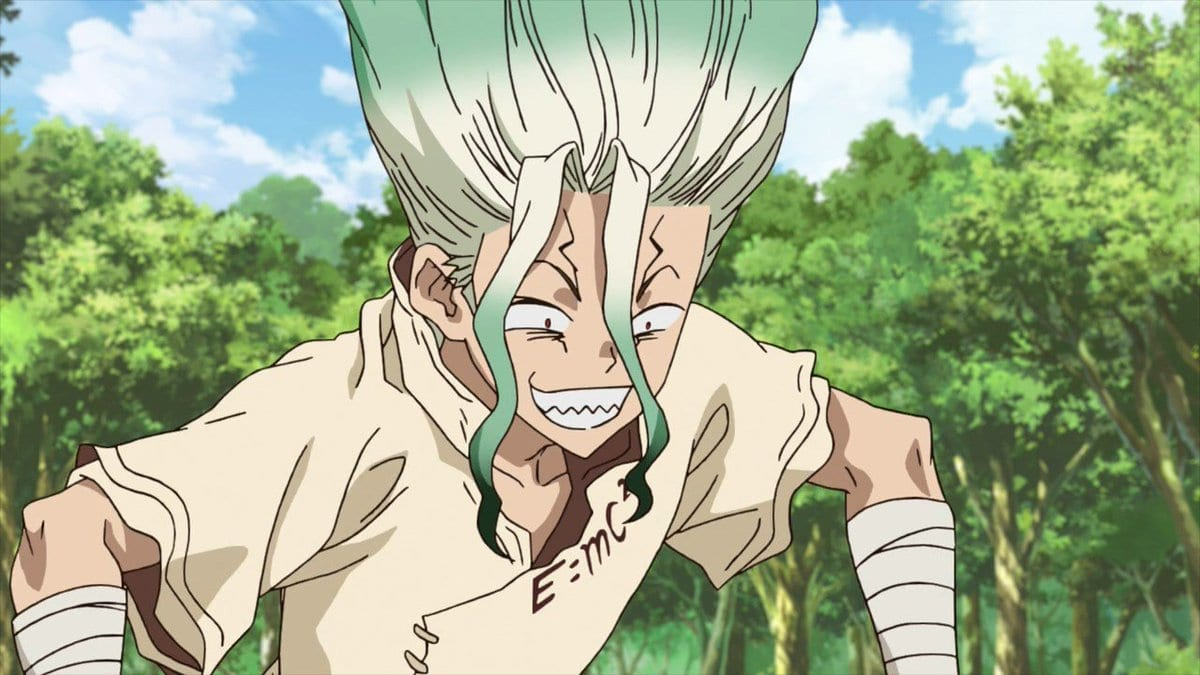